In [1]:
import numpy as np
import pandas as pd

In [2]:
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('./Data/training.1600000.processed.noemoticon.csv',encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

In [3]:
# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]
# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

In [4]:
# plotting the number of positive and negative sentiments
import matplotlib.pyplot as plt

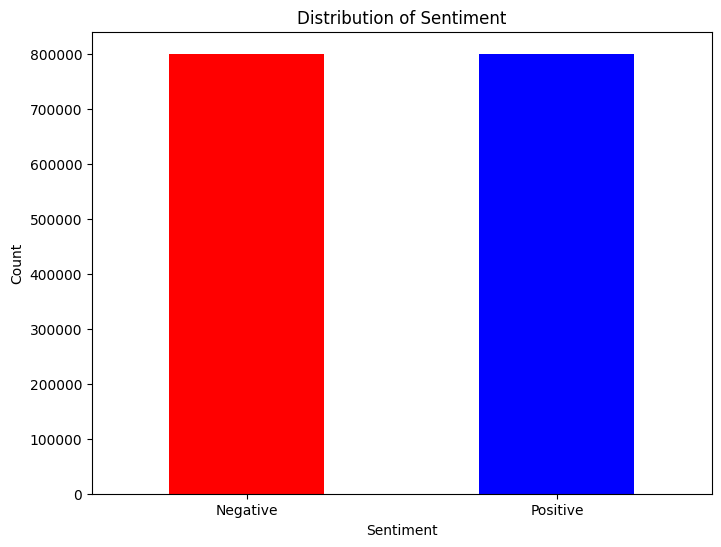

In [5]:
sentiment_counts = dataset['sentiment'].value_counts()

plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['red', 'blue'])
plt.title('Distribution of Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0, ticks=[0, 1], labels=['Negative', 'Positive'])
plt.show()

In [6]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [7]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to C:\Users\Karthik
[nltk_data]     Shetty\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Karthik
[nltk_data]     Shetty\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
from nltk.corpus import stopwords

# Get the list of stopwords
stopwordlist = stopwords.words('english')

In [9]:
import re
from nltk.stem import WordNetLemmatizer

In [10]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to ''.
        tweet = re.sub(userPattern,'', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [11]:
# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

In [12]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 149 seconds


In [13]:
# !pip install wordcloud

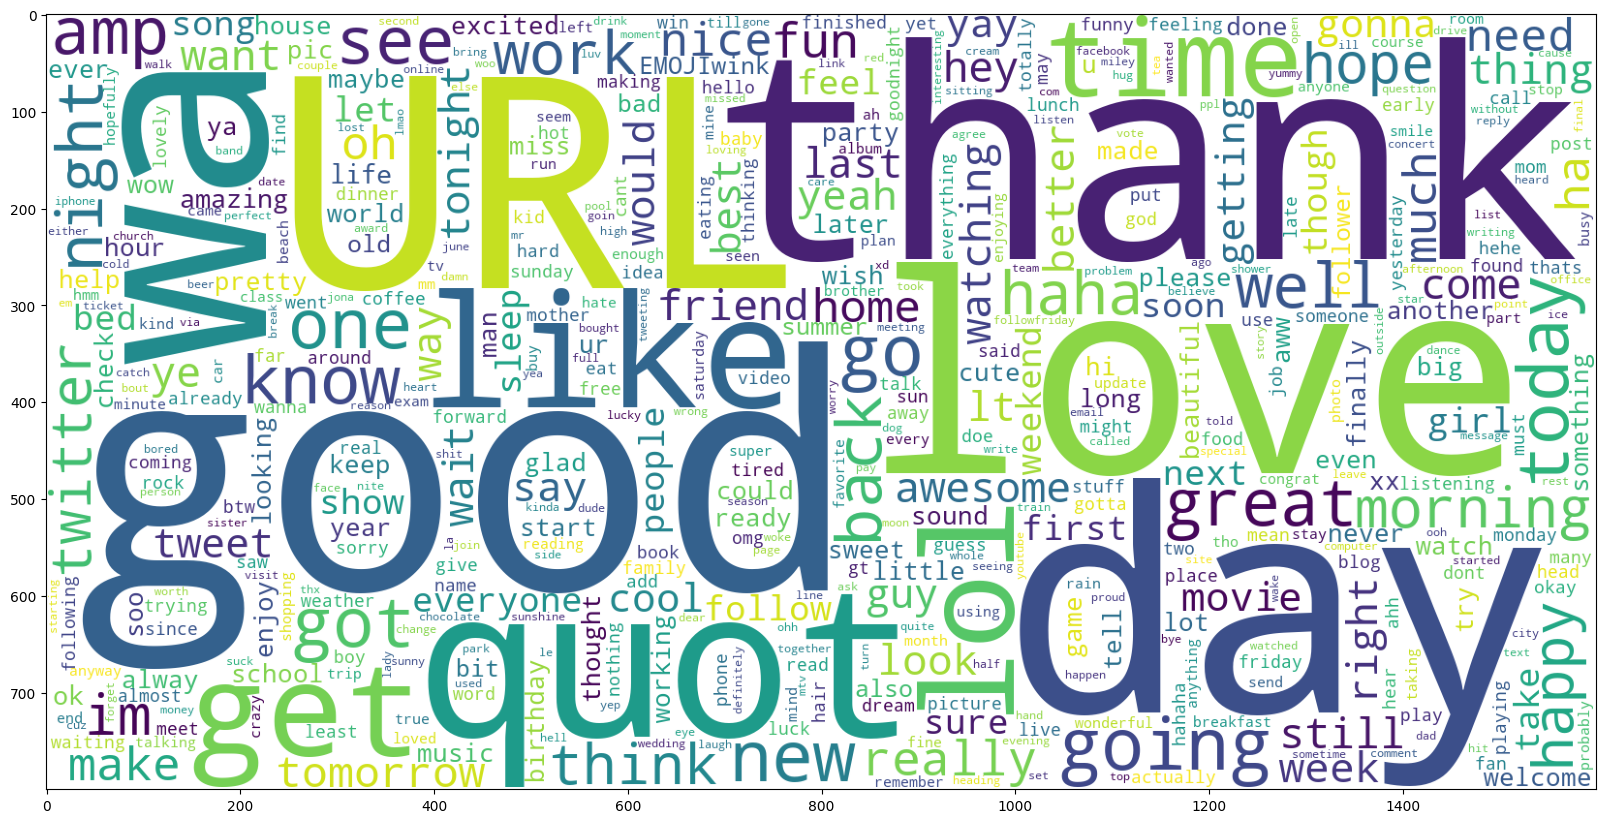

In [14]:
from wordcloud import WordCloud

data_pos = processedtext[800000:]
wc = WordCloud(max_words = 500 , width = 1600 , height = 800, collocations=False,background_color="white", stopwords=stopwordlist).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

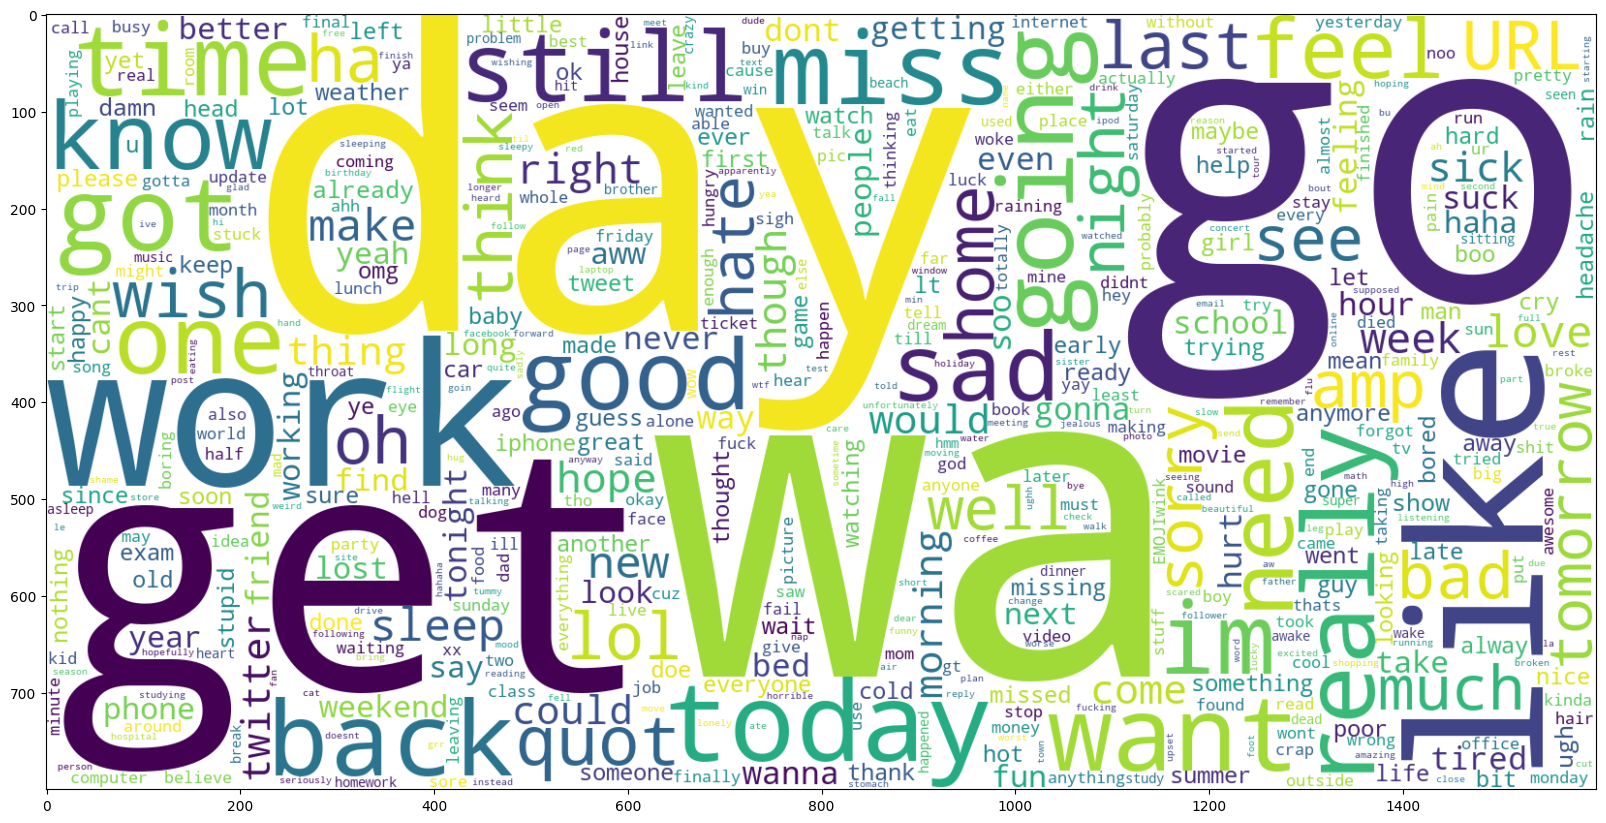

In [15]:
data_neg = processedtext[:800000]
stopwordlist.append('user')
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 500 , width = 1600 , height = 800, collocations=False, background_color="white", stopwords=stopwordlist).generate(" ".join(data_neg))
plt.imshow(wc,interpolation='bilinear')

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment, test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [19]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

Vectoriser fitted.
No. of feature_words:  500000


In [20]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [22]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [23]:
from sklearn.linear_model import LogisticRegression

              precision    recall  f1-score   support

           0       0.83      0.82      0.82     39989
           1       0.82      0.83      0.83     40011

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



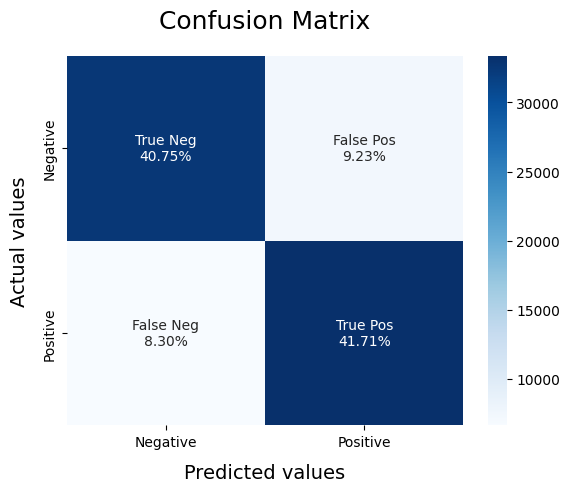

In [24]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

In [25]:
import pickle

# Define a filename for the saved model
filename = 'LRmodel.pkl'

# Save the model to disk using pickle
with open(filename, 'wb') as file:
    pickle.dump(LRmodel, file)

print(f"Model saved as {filename}")

Model saved as LRmodel.pkl


In [26]:
file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

In [28]:
import pickle

def load_models():
    # Load the LR Model.
    filename = 'Saved-Model\LRmodel.pkl'  # Update the path to match the saved model location
    with open(filename, 'rb') as file:
        LRmodel = pickle.load(file)
    
    return LRmodel

def predict(model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

if __name__=="__main__":
    # Loading the models.
    LRmodel = load_models()  # Assuming vectoriser is already defined elsewhere
    
    # Text to classify should be in a list.
    text = ["I hate twitter",
            "May the Force be with you.",
            "Mr. Stark, I don't feel so good"]
    
    df = predict(LRmodel, text)  # Passing only LRmodel as an argument
    print(df.head())

                              text sentiment
0                   I hate twitter  Negative
1       May the Force be with you.  Positive
2  Mr. Stark, I don't feel so good  Negative
